# Model Training
- Author: Myles Dunlap


This notebook is used to train a model using a single configuration file. The steps in this notebook are used in the Python script.

# User Inputs

In [16]:
# Append the path for the custom modules
path_custom_modules = '../'

# Path to the YAML config. file
path_cfg = {'base_dir': '../cfgs',
            'filename': 'train-0.yaml'}

# Import Libraries and Modules

In [17]:
# Libraries
import sys
import os
from pathlib import Path

import torch
import argparse
import inspect

# Append Path to Custom Modules
sys.path.append(path_custom_modules)

# Custom Modules
from src.models import llm_multiclass
from src.utils import (RecursiveNamespace,
                       seed_everything,
                       load_cfg,
                       RunIDs)
from src.dataloading.load_data import LoadData
from src.dataloading.stratify import StratifyData
from src.dataloading.preprocess import PreprocessData
from src.dataloading.load_datasets import (TrainDataset,
                                           CustomTextCollator,
                                           )

# Allow HF tokenizer parallelism
os.environ['TOKENIZERS_PARALLELISM'] = 'True'
os.environ['TRANSFORMERS_NO_ADVISORY_WARNINGS'] = 'true'

In [18]:
# Load the configuration file
CFG = load_cfg(base_dir=Path(path_cfg['base_dir']),
               filename=path_cfg['filename'])

# Set random seed on everything
seed_everything(seed=CFG.seed)

# Get Device type for processing (CPU/GPU)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [19]:
# Group ID and ID for each fold tested
run_ids = RunIDs(test_folds=CFG.cv.val_folds,
                 num_folds=CFG.cv.num_folds)
run_ids.generate_run_ids()

# Print the group id and ids for each fold
print(f'Group ID: {run_ids.group_id}')
for fold_num in CFG.cv.val_folds:
    fold_id = getattr(run_ids.folds_id,
                      f'fold{fold_num}').run_id
    entire_id = f'{run_ids.group_id}-{fold_id}' 
    print((f'ID for Testing Fold #{fold_num}: '
           f'{fold_id}\n\tFull/Entire ID: {entire_id}'))

Group ID: d1c63d73
ID for Testing Fold #1: b92a9cce
	Full/Entire ID: d1c63d73-b92a9cce
ID for Testing Fold #2: e76b6ba5
	Full/Entire ID: d1c63d73-e76b6ba5
ID for Testing Fold #3: 178cb679
	Full/Entire ID: d1c63d73-178cb679
ID for Testing Fold #4: 55d1d519
	Full/Entire ID: d1c63d73-55d1d519
ID for Testing Fold #5: d3da6f3b
	Full/Entire ID: d1c63d73-d3da6f3b


In [20]:
# Load Data from Disk
load_data_file = LoadData(base_dir=CFG.paths.data.base_dir)
if CFG.debug:
    data = load_data_file.load(filename=CFG.paths.data.debug_data)
else:
    data = load_data_file.load(filename=CFG.paths.data.data)


In [21]:
# Stratify the Data
data = (StratifyData(technique=CFG.stratify.technique,
                     n_folds=CFG.cv.num_folds,
                     target=CFG.data_info.target)
            .stratify(df=data))
cols = CFG.data_info.source_fields + \
       [CFG.data_info.target, 'fold']

# Number of classes for downstream use
N_CLASSES = data[CFG.data_info.target].nunique()

# Print information
display(data[cols].head(5))
print(f'Distribution of a Product for Each Fold')
print(f'Notice how the quantities are evenly distributed across folds')
display(data.groupby('Product').fold.value_counts()
        .sort_index().head(5))

,Consumer complaint narrative,Issue,Sub-issue,Product,fold
0,I AM A VICTIM OF IDENTITY THEFT. There were ac...,Problem with a credit reporting company's inve...,Their investigation did not fix an error on yo...,"Credit reporting, credit repair services, or o...",1
1,Send Company a validation of debt communicatio...,Written notification about debt,Didn't receive enough information to verify debt,Debt collection,1
2,There are many mistakes appear in my report wi...,Incorrect information on your report,Account information incorrect,"Credit reporting, credit repair services, or o...",1
3,"On XX/XX/2019, I paid {$1600.00} on my card en...",Trouble using your card,Credit card company won't increase or decrease...,Credit card or prepaid card,1
4,I had money from the VA that was due to me sin...,Dealing with your lender or servicer,Trouble with how payments are being handled,Student loan,1


Distribution of a Product for Each Fold
Notice how the quantities are evenly distributed across folds


Product                      fold
Credit card or prepaid card  1       200
                             2       200
                             3       200
                             4       200
                             5       200
Name: count, dtype: int64

# Start looping over folds here

In [22]:
from torch.utils.data import DataLoader
# Train a model for each validation fold
fold_num = CFG.cv.val_folds[0]

# Split Data into Training and Validation
df_train = data.copy()[data.fold != fold_num].reset_index(drop=True)
df_val = data.copy()[data.fold == fold_num].reset_index(drop=True)
print(f'Train Number of Instances: {len(df_train):,}')
print(f'Validation Number of Instances: {len(df_val):,}')

Train Number of Instances: 3,200
Validation Number of Instances: 800


# Preprocess Target

Convert the text target into a label.

In [23]:
# Preprocessing Encoders
encoders = {}
for technique in CFG.preprocessing.apply_techniques:
    fields = getattr(CFG.preprocessing, technique).fields
    for col in fields:
        enc = PreprocessData(y=df_train[col].values,
                             technique=technique)
        encoders[col] = {'encoder': enc.encoder,
                         'technique': technique}

# Tokenizer and Collator

A collator is an object that forms a batch of data by using a list of dataset elements as inputs. A custom text collator is used here and it has several benefits such as:
- the data does **NOT** have to be tokenizer prior to being passed to the PyTorch DataLoader class. This means the text data is tokenized once a batch of data is processed in in the DataLoader class and it allows for RAM usage to stay lower. For example, if your dataset exceeds the available RAM size then tokenizing all the data prior to the DataLoader (e.g., in the Dataset class) it will become problematic.
- This enables dynamic padding over the batches. Later the maximum token length for a few batches will be printed to illustrate the dynamic padding. This ultimately leads to faster processing of data as explain in this [HuggingFace YouTube video](https://www.youtube.com/watch?v=7q5NyFT8REg).



In [24]:
from transformers import AutoTokenizer, DataCollatorWithPadding
# Path to the model and tokenizer model card saved on disk
model_path = Path(CFG.model_tokenizer.base_dir) / CFG.model_tokenizer.name

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_path, do_lower=True)

# Collator
collator = CustomTextCollator(tokenizer=tokenizer,
                              tokenizer_cfg=CFG.tokenizer)

## Combine all mix-data type fields

In this [blob post by Chris McCormick](https://mccormickml.com/2021/06/29/combining-categorical-numerical-features-with-bert/) an interesting approach was taken to combine mixed data types which was to convert all categorical and numerical into the text feed into the LLM. This repository will try this technique ingle string that will be processed by the LLM. 

Another approach is only pass the unstructured text into the LLM, take its last layer output and combine with the other mixed data types into a dense layer. This type of approach seems more common and an example can be found on [Google Colab here](https://colab.research.google.com/drive/1F7COnwHqcLDPg_SS-oFgW3c2GPDWnS5Y#scrollTo=BAQFbN-wBpoz).

In [25]:
# Train Dataset and Dataloader
train_dataset = TrainDataset(df=df_train,
                             tok=tokenizer,
                             tok_cfg=CFG.tokenizer,
                             X_cols=CFG.data_info.source_fields,
                             label=CFG.data_info.target,
                             encoder=encoders[CFG.data_info.target]['encoder'])
train_dataloader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size,
                              collate_fn=collator,
                              shuffle=True,
                              num_workers=CFG.num_workers,
                              pin_memory=True,
                              )

# Validation Dataset and Dataloader
val_dataset = TrainDataset(df=df_val,
                           tok=tokenizer,
                           tok_cfg=CFG.tokenizer,
                           X_cols=CFG.data_info.source_fields,
                           label=CFG.data_info.target,
                           encoder=encoders[CFG.data_info.target]['encoder'])
val_dataloader = DataLoader(val_dataset,
                            batch_size=CFG.batch_size,
                            collate_fn=collator,
                            shuffle=True,
                            num_workers=CFG.num_workers,
                            pin_memory=True,
                            )

# Total number of steps/iterations
total_steps = CFG.epochs * len(train_dataloader)

print(f'# of Training Samples: {len(df_train):,}')
print(f'# of Validation Samples: {len(df_val):,}')
print(f'Batch Size: {CFG.batch_size}')
print(f'{len(df_train):,} \ {CFG.batch_size:,} = {len(train_dataloader):,}')
print(f'Train DataLoader # of Iters: {len(train_dataloader):,}')
print(f'Val. DataLoader # of Iters: {len(val_dataloader):,}')

# Dynamic Padding of Maximum Token Lengths
print(f'\nDynamic Padding\n\tThe shape is [batch size, maximum token length]')
for i, inputs in enumerate(train_dataloader):
    if i > 10:
        break
    else:
        print((f'Batch {i + 1} of {len(train_dataloader):,}: '
               f'{inputs["input_ids"].shape}'))

# of Training Samples: 3,200
# of Validation Samples: 800
Batch Size: 16
3,200 \ 16 = 200
Train DataLoader # of Iters: 200
Val. DataLoader # of Iters: 50

Dynamic Padding
	The shape is [batch size, maximum token length]
Batch 1 of 200: torch.Size([16, 512])
Batch 2 of 200: torch.Size([16, 400])
Batch 3 of 200: torch.Size([16, 512])
Batch 4 of 200: torch.Size([16, 512])
Batch 5 of 200: torch.Size([16, 416])
Batch 6 of 200: torch.Size([16, 512])
Batch 7 of 200: torch.Size([16, 512])
Batch 8 of 200: torch.Size([16, 512])
Batch 9 of 200: torch.Size([16, 512])
Batch 10 of 200: torch.Size([16, 487])
Batch 11 of 200: torch.Size([16, 457])


# Load the Model

- Generic HF info. on Bert: [HuggingFace Bert](https://huggingface.co/docs/transformers/model_doc/bert)
- HF Model Card for: [bert-base-uncased](https://huggingface.co/bert-base-uncased)

In [26]:
from src.models.llm_multiclass import CustomModel
# Load custom model
model = CustomModel(llm_model_path=model_path,
                    cfg=CFG.model,
                    num_classes=N_CLASSES)

# Set model on device
model.to(DEVICE)
!nvidia-smi

Tue Jul 25 21:07:05 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 520.61.05    Driver Version: 520.61.05    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0 Off |                  N/A |
|  0%   55C    P2   110W / 350W |   1715MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Optimizer

In [27]:
from src.training.optimizers import get_optimizer
# Optimizer
optimizer = get_optimizer(cfg=CFG.optimizer,
                          model=model)

# Learning Rate Finder

A [PyTorch implementation](https://pypi.org/project/torch-lr-finder/) of the learning rate range test detailed in Cyclical Learning Rates for Training Neural Networks by Leslie N. Smith and the tweaked version used by fastai.

In [28]:
# from torch_lr_finder import LRFinder, TrainDataLoaderIter
# from torch import nn

# class TrainIter(TrainDataLoaderIter):
#     def inputs_labels_from_batch(self, batch):
#         return ({'input_ids': batch['input_ids'],
#                  'attention_mask': batch['attention_mask']},
#                 batch['labels'])
# train_data_iter = TrainIter(train_dataloader)

# # Learning Rate Finder
# lr_finder = LRFinder(model,
#                      torch.optim.AdamW(model.parameters(), lr=1.0E-7),
#                      nn.CrossEntropyLoss(),
#                      device="cuda")
# lr_finder.range_test(train_data_iter,
#                      end_lr=0.2,
#                      num_iter=100,
#                      step_mode="linear")
# lr_finder.plot(log_lr=False)
# lr_finder.reset()

# Learning Rate Scheduler

Learning rate schedulers can be used to help an algorithm converge to a more optimal solution. Please refer to this references for more information and a visual representation of various learning rate schedules.
 - [Medium Article](https://towardsdatascience.com/a-visual-guide-to-learning-rate-schedulers-in-pytorch-24bbb262c863)
 - [Kaggle Notebook](https://www.kaggle.com/code/isbhargav/guide-to-pytorch-learning-rate-scheduling)

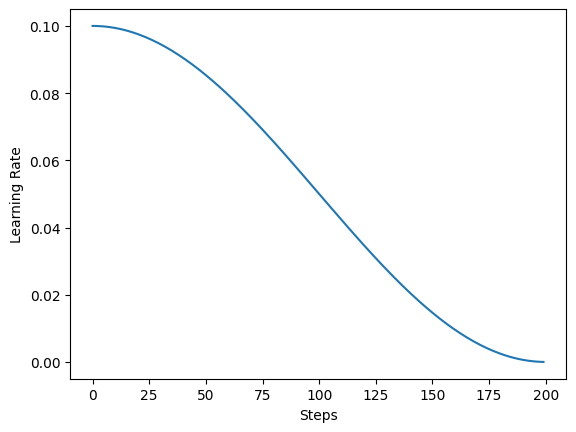

In [29]:
from torch.optim.lr_scheduler import CosineAnnealingLR, OneCycleLR
import matplotlib.pyplot as plt
import gc
# Learning rate scheduler
# scheduler = OneCycleLR(optimizer=optimizer,
#                        total_steps=total_steps,
#                        max_lr=CFG.optimizer.lr.max)

scheduler = CosineAnnealingLR(optimizer,
                              T_max=total_steps,
                              eta_min=CFG.optimizer.lr.min)
lr_value = []
steps = []
step_count = 0
for epoch in range(CFG.epochs):
    for batch_count in range(len(train_dataloader)):
        optimizer.step()
        lr_value.append(optimizer.param_groups[0]['lr'])
        steps.append(step_count)
        scheduler.step()
        step_count +=1

# Re-establish optimizer and scheduler since they were called
del optimizer, scheduler
_ = gc.collect()

# Optimizer
optimizer = get_optimizer(cfg=CFG.optimizer,
                          model=model)

# Learning rate scheduler
# scheduler = OneCycleLR(optimizer=optimizer,
#                        total_steps=total_steps,
#                        max_lr=CFG.optimizer.lr.max,
#                        pct_start=CFG.lr_scheduler.pct_start)
scheduler = CosineAnnealingLR(optimizer,
                              T_max=total_steps,
                              eta_min=CFG.optimizer.lr.max)

# Plot Learning Rate Schedule
plt.plot(steps, lr_value)
plt.xlabel('Steps')
plt.ylabel('Learning Rate')
plt.show()

# Training

### Loss Functions References
- [Machine Learning Mastery](https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/)
- [Neptune AI Article](https://neptune.ai/blog/pytorch-loss-functions)
- [PyTorch Loss Functions](https://pytorch.org/docs/stable/nn.html#loss-functions)

Since this is a multi-class classification we can use nn.CrossEntropyLoss as the loss function. More elborate modules can be built for selecting and creating custom loss functions.

### Performance Metrics

[TorchMetrics](https://torchmetrics.readthedocs.io/en/latest/) will be used for implementing performance metrics.
- [F1-Score](https://torchmetrics.readthedocs.io/en/stable/classification/f1_score.html)
- [Precision]()
- [Recall]()

In [30]:
# # # # # idx=0
# # batch = next(iter(train_dataloader))
# X = {'input_ids': batch['input_ids'].to(DEVICE),
#     'attention_mask': batch['attention_mask'].to(DEVICE)}
# y = batch['labels'].to(DEVICE)

# # # # f1 = multiclass_f1_score(y_pred, y, num_classes=N_CLASSES)
# # # # Model prediction
# y_pred_logits = model(X)
# # # y_pred = torch.softmax(y_pred_logits, axis=1)
# # # f1_score = multiclass_f1_score(y_pred, y, num_classes=N_CLASSES)
# # # f1_score
# # # X
# # y_pred_logits

In [31]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

#compute the class weights
train_labels = encoders['Product']['encoder'].transform(df_train['Product'])
class_wts = compute_class_weight('balanced',
                                 classes=np.unique(train_labels),
                                 y=train_labels)

# convert class weights to tensor
weights= torch.tensor(class_wts, dtype=torch.float)
weights = weights.to(DEVICE)

In [32]:
import time
from src.training.metrics import AverageMeter
from tqdm import tqdm
from torch import nn
# from torchmetrics.classification import (MulticlassF1Score,
#                                          MulticlassPrecision,
#                                          MulticlassRecall)
from torcheval.metrics.functional import (multiclass_f1_score,
                                          multiclass_precision,
                                          multiclass_recall)
from torch.nn.functional import one_hot


# Batch size
batch_size = CFG.batch_size

# Loss Function
loss_fn = nn.CrossEntropyLoss(weight=weights)
# loss_fn = nn.BCELoss()

# # Performance metrics
# f1 = MulticlassF1Score(num_classes=N_CLASSES).to(DEVICE)
# precision = MulticlassPrecision(num_classes=N_CLASSES).to(DEVICE)
# recall = MulticlassRecall(num_classes=N_CLASSES).to(DEVICE)

# Training loop over epochs
start_training_time = time.time()
step_count = 0
best_score = 0.0
for epoch in range(CFG.epochs):
    epoch_start_time = time.time()
    print(f'\nStart Epoch {epoch + 1}')
    train_meters = {
        'loss': AverageMeter(),
        'f1': AverageMeter(),
        'precision': AverageMeter(),
        'recall': AverageMeter(),
    }
    model.train()
    
    # TRAINING
    # Iterate over each batch in an epoch
    # for idx, batch in enumerate(train_dataloader): [if you don't want a progress bar]
    with tqdm(train_dataloader, unit='batch') as tepoch:
        for batch in tepoch:
            tepoch.set_description(f"Epoch {epoch}")
            X = {'input_ids': batch['input_ids'].to(DEVICE),
                'attention_mask': batch['attention_mask'].to(DEVICE)}
            y = batch['labels'].to(DEVICE)
            # y = one_hot(y, num_classes=N_CLASSES)

            # Model prediction
            # model.zero_grad()
            optimizer.zero_grad()
            y_pred_logits = model(X)
            y_pred = torch.softmax(y_pred_logits, axis=1)
            
            # Calculate loss
            loss = loss_fn(input=y_pred, target=y)
            
            # Backward pass, optimizer & scheduler steps
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            # Performance metrics for the batch of data
            f1_score = multiclass_f1_score(y_pred, y, num_classes=N_CLASSES)
            precision_score = multiclass_precision(y_pred, y, num_classes=N_CLASSES)
            recall_score = multiclass_recall(y_pred, y, num_classes=N_CLASSES)
            
            # Store loss and performance metrics
            train_meters['loss'].update(loss.detach().cpu().numpy(),
                                        n=batch_size)
            train_meters['f1'].update(f1_score.detach().cpu().numpy(),
                                      n=batch_size)
            train_meters['precision'].update(precision_score.detach().cpu().numpy(),
                                             n=batch_size)  
            train_meters['recall'].update(recall_score.detach().cpu().numpy(),
                                          n=batch_size) 

            if step_count % 10 == 0:
                tepoch.set_postfix(loss=f'{train_meters["loss"].avg:.4f}',
                                   f1=f'{train_meters["f1"].avg:.3f}',
                                   precision=f'{train_meters["precision"].avg:.3f}',
                                   recall=f'{train_meters["recall"].avg:.3f}')
            step_count += 1

    # Print training time
    print(f'Epoch {epoch + 1} Training Time: '
            f'{(((time.time() - epoch_start_time) / 60) / 60):.1f} hrs.')
    
    # # VALIDATION
    # val_meters = {
    #     'loss': AverageMeter(),
    #     'cos': AverageMeter(),
    #     }
    # model.eval()
    # for X, y in dataloaders['val']:
    #     X, y = X.to(device), y.to(device)

    #     with torch.no_grad():
    #         X_out = model(X)
    #         target = torch.ones(X.size(0)).to(device)
    #         loss = criterion(X_out, y, target)

    #         val_loss = loss.item()
    #         val_cos = cosine_similarity(
    #             X_out.detach().cpu().numpy(), 
    #             y.detach().cpu().numpy()
    #         )

    #     val_meters['loss'].update(val_loss, n=X.size(0))
    #     val_meters['cos'].update(val_cos, n=X.size(0))

    # print('Epoch {:d} / val/loss={:.4f}, val/cos={:.4f}'.format(
    #     epoch + 1,
    #     val_meters['loss'].avg,
    #     val_meters['cos'].avg))
    

    # # Save best model to disk
    # if val_meters['cos'].avg > best_score:
    #     best_score = val_meters['cos'].avg
    #     torch.save(model.state_dict(), model_save_path)



Start Epoch 1


Epoch 0: 100%|██████████| 200/200 [01:04<00:00,  3.08batch/s, f1=0.249, loss=1.4937, precision=0.249, recall=0.249]

Epoch 1 Training Time: 0.0 hrs.
